In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Drawing bounding boxes

In [2]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    newImg = img.copy()
    for box in bboxes:
        cv2.rectangle(newImg, box[0], box[1], color, thick)
    return newImg

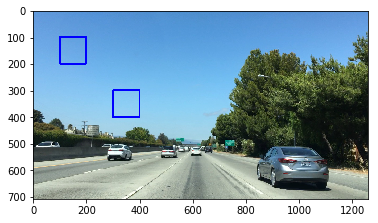

In [3]:
image = mpimg.imread('bbox-example-image.jpg')
bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
result = draw_boxes(image, bboxes)
plt.imshow(result)

## Template Matching

In [4]:
image = mpimg.imread('bbox-example-image.jpg')
templist = ['templates/cutout1.jpg', 'templates/cutout2.jpg', 'templates/cutout3.jpg',
            'templates/cutout4.jpg', 'templates/cutout5.jpg', 'templates/cutout6.jpg']

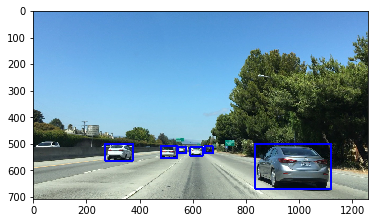

In [5]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    method = cv2.TM_CCORR_NORMED
    bbox_list = []
    for url in template_list:
        tmp = mpimg.imread(url)
        result = cv2.matchTemplate(img, tmp, method=method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

## Color histogram

In [6]:
image = mpimg.imread('templates/cutout1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    


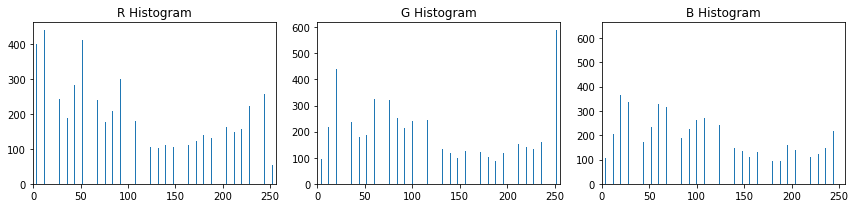

In [7]:
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

## Color spaces

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


In [9]:
# Read a color image
img = cv2.imread("000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

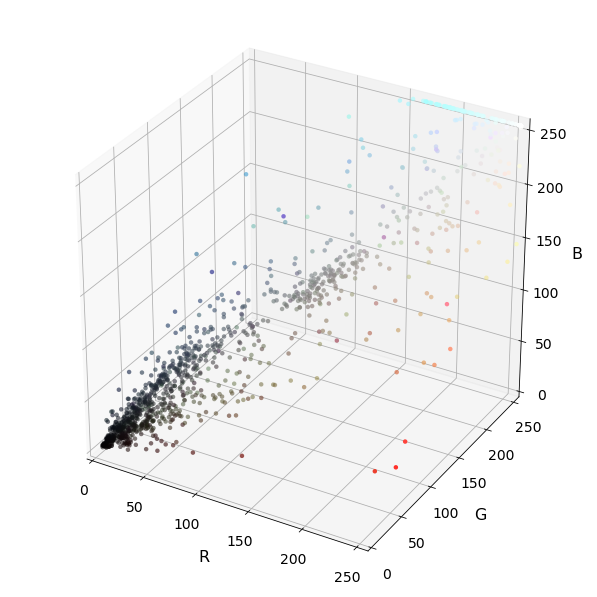

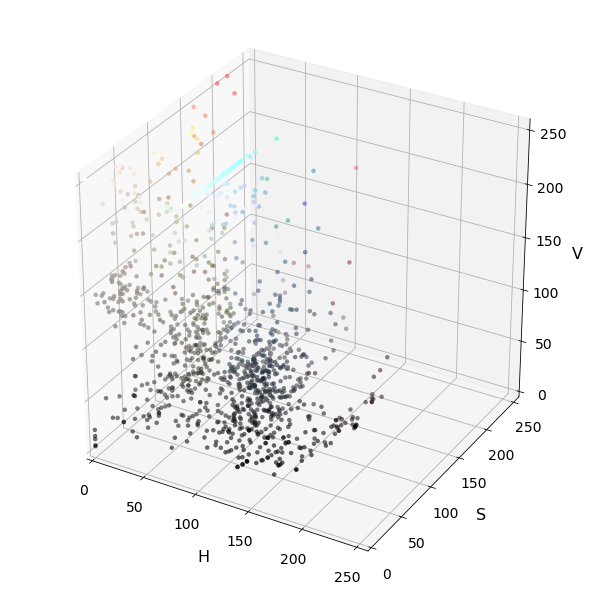

In [10]:
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

## Spatial Binning

In [11]:
# Define a function that takes an image, a color space, 
# and a new image size
# and returns a feature vector
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    feature_vector = cv2.resize(img, size).ravel()
    return feature_vector

Text(0.5,1,'Spatially Binned Features')

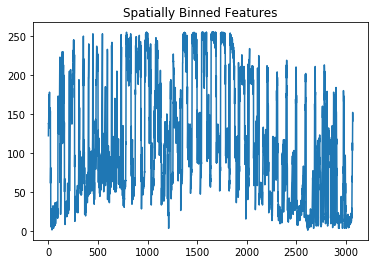

In [12]:
image = mpimg.imread('templates/cutout1.jpg')
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

## HOG (Histrogram of Oriented Gradients)

In [13]:
from skimage.feature import hog

In [14]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                      cells_per_block=(cell_per_block,cell_per_block),
                      block_norm='L2', visualize=vis, feature_vector=feature_vec)
    hog_features = return_list
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

Text(0.5,1,'HOG Visualization')

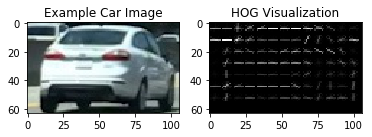

In [15]:
image = mpimg.imread('templates/cutout1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(1)
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Combining Features

In [16]:
from sklearn.preprocessing import StandardScaler
import glob

In [17]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    features = []
    for img_url in imgs:
        img = mpimg.imread(img_url)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        spatial_features = bin_spatial(feature_image, cspace, spatial_size)
        _,_,_,_,color_features = color_hist(feature_image, hist_bins, hist_range)
        features.append(np.concatenate((spatial_features, color_features)))
    return features

In [18]:
images = glob.glob('templates/*.jpg')
features = extract_features(images, cspace='RGB', spatial_size=(32, 32),
                            hist_bins=32, hist_range=(0, 256))

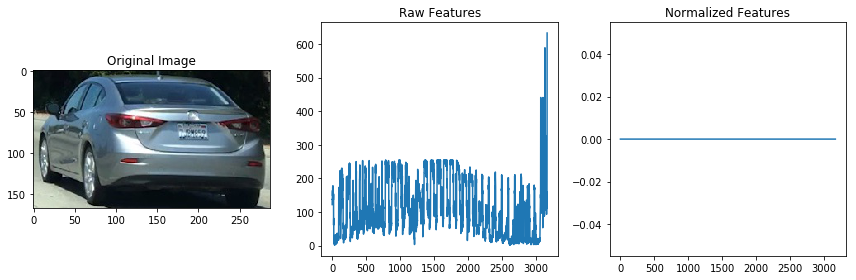

In [20]:
# X = np.vstack(features).astype(np.float64)
X = features
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(images))
# # Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(images[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()